# Convolutional Neural Networks

The standard neural network we looked at in the previous lesson takes in a vector as input thus a flattened image could be passed in as input and used for classification problems successfully. But this is not the best way to do it. If you think about an image, the spatial relations between the different pixels is an important piece of information when determening what the image is. If we scrambled the pixels of an image, it would be much harder to determine what is in it. This is basically what we are doing when we flatten the image and use standard NNs as the order of pixels which we use in the input vector to the network does not affect the performance of the NN. We are losing the information of the spatial relations of the pixels.

Convolutional neural networks solve this very problem. Rather than performing a matrix multiplication, a convolution operation is performed which can take in a 2d input and give a 2d output hence keep the information about the spatial relations of the pixels. This greatly increases their performance on image and video processing tasks.

In the convolution proccess, you have a filter which you start on the top left side of the image and slide across the whole image, taking a dot product between the values of the filter and pixel values of the image. Bear in mind that colour images have three channels so your filter may be 3-d so you take the dot product across a 3d-volume. Each dot product corresponds to a single activation value in a 2-d matrix of neurons which corresponds to a single layer in the output.

The animation below shows how a 1x3x3 filter is applied to a 1x5x5 image. Notice how the filter has high output values when there is an X shape in the input image. This is because the values of the filter are such that it is performing pattern matching for the X shape.

![](cnn.gif)

For a long time, operations like this were used in computer vision to find different patterns in images with the engineers having to manually tune the values of the filters to perform the required function. The only difference now is that we apply an activation such as Relu or Sigmoid at each layer and after setting up the structure of the network, we initialize the filter values randomly before using gradient descent to automatically tune the values of the filters.
We can also apply pooling operations to subsample the output at each layer therefore reducing the number of parameters that need to be learned for the next convolution operation.

![](cnn.png)

Just like before, each layer in the whole network learns higher level abstract features from the inputs. In CNNs the features are even more interpretable as the output of each layer is 2d so can be viewed as an image.

## Implementation
we will be implementing a CNN which can take as input a 1x28x28 black and white images of hand-written digits and classifying it into which digit the image depicts. We have a dataset of 60,000 images and their corresponding labels to train on and 10,000 to test on. This is called the MNIST dataset.

Lets import the necessary libraries

In [1]:
%matplotlib notebook
import torch
from torch.autograd import Variable
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt

Import the MNIST training and test sets from the default PyTorch datasets

(tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  

<IPython.core.display.Javascript object>


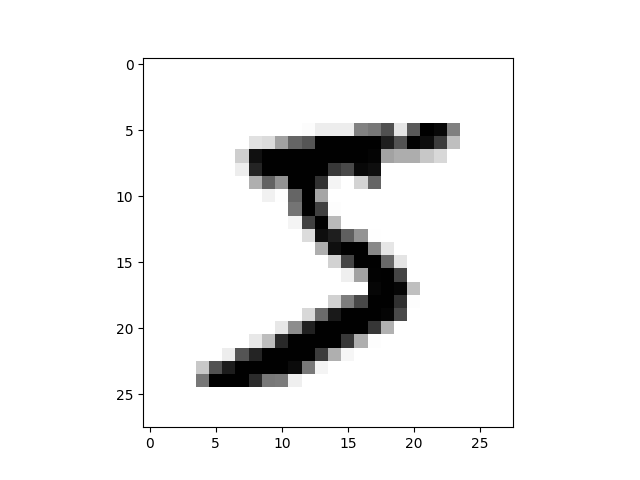

Number of training examples: 60000
Number of test examples: 10000


In [2]:
training_data = datasets.MNIST(root='data/',
                                  transform=transforms.ToTensor(),
                                  train=True,
                                  download=True,
                               )

test_data = datasets.MNIST(root='data/',
                           transform=transforms.ToTensor(),
                           train=False,
                            )

#show our first training data item
print(training_data[0])
plt.imshow(training_data[0][0][0], cmap='gray_r')
plt.show()

print('Number of training examples:', len(training_data))
print('Number of test examples:', len(test_data))

Create dataloader generator from our datasets. Dataloaders generate random samples from the training set and the test set (not randomly from the test set as it doesn't affect our results).

In [3]:
batch_size = 128

# dataloader is a generator that can sample from the training set
training_samples = torch.utils.data.DataLoader(dataset=training_data,
                                              batch_size=batch_size,
                                              shuffle=True)

test_samples = torch.utils.data.DataLoader(dataset=test_data,
                                            batch_size=batch_size,
                                            shuffle=False)

Define the model calss, it is a 2 layer convnet with a fully connected layer at the end to map it to 10 output neurons, each corresopnding to the probability of the input image being a particular digit

In [4]:
class convnet(torch.nn.Module):

    def __init__(self):
        super().__init__()
            # conv2d(in_channels, out_channels, kernel_size)
            # in_channels is the number of layers which it takes in (i.e.num color streams in 1st layer)
            # out_channels is the number of different filters that we use
            # kernel_size is the depthxwidthxheight of the kernel#
            # stride is how many pixels we shift the kernel by each time
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=5, stride=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=5, stride=1)
        self.dense1 = torch.nn.Linear(25600, 10)

    def forward(self, x):
        x = F.relu((self.conv1(x)))
        x = F.relu((self.conv2(x))).view(x.shape[0], -1) #flatten output ready for fully connected layer
        x = F.softmax(self.dense1(x), dim=1) #fully connected layer with softmax activation
        
        return x

Define hyper-parameters, cost function, optimizer and instantiate model

In [5]:
lr = 0.0001 #learning rate
epochs = 1 #number of epochs

cnn = convnet() #instantiate model
criterion = torch.nn.CrossEntropyLoss() #cost function
optimizer = torch.optim.Adam(cnn.parameters(), lr=lr) #optimizer

Define training loop and train for the number of epochs. Since our dataset is huge and an epoch takes a while to complete, we will plot our cost every batch rather than every epoch.

<IPython.core.display.Javascript object>


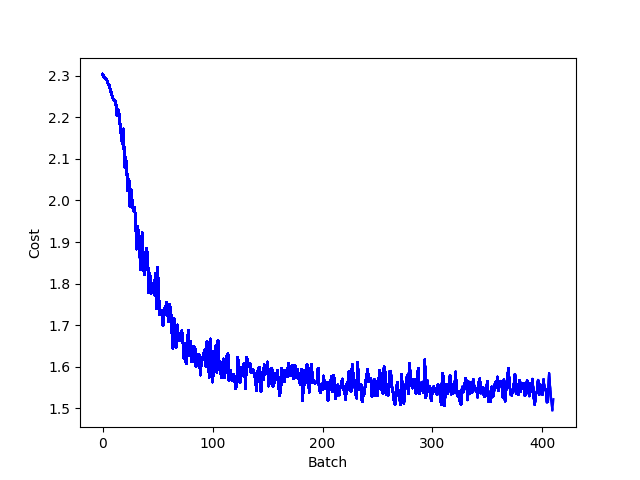

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:26: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0 	Batch 0 	Cost tensor(2.3028)
Epoch 0 	Batch 1 	Cost tensor(2.2985)
Epoch 0 	Batch 2 	Cost tensor(2.2946)
Epoch 0 	Batch 3 	Cost tensor(2.2919)
Epoch 0 	Batch 4 	Cost tensor(2.2887)
Epoch 0 	Batch 5 	Cost tensor(2.2811)
Epoch 0 	Batch 6 	Cost tensor(2.2762)
Epoch 0 	Batch 7 	Cost tensor(2.2663)
Epoch 0 	Batch 8 	Cost tensor(2.2572)
Epoch 0 	Batch 9 	Cost tensor(2.2484)
Epoch 0 	Batch 10 	Cost tensor(2.2417)
Epoch 0 	Batch 11 	Cost tensor(2.2397)
Epoch 0 	Batch 12 	Cost tensor(2.2373)
Epoch 0 	Batch 13 	Cost tensor(2.2044)
Epoch 0 	Batch 14 	Cost tensor(2.2182)
Epoch 0 	Batch 15 	Cost tensor(2.2089)
Epoch 0 	Batch 16 	Cost tensor(2.1797)
Epoch 0 	Batch 17 	Cost tensor(2.1559)
Epoch 0 	Batch 18 	Cost tensor(2.1358)
Epoch 0 	Batch 19 	Cost tensor(2.1718)
Epoch 0 	Batch 20 	Cost tensor(2.0800)
Epoch 0 	Batch 21 	Cost tensor(2.1034)
Epoch 0 	Batch 22 	Cost tensor(2.0739)
Epoch 0 	Batch 23 	Cost tensor(2.0232)
Epoch 0 	Batch 24 	Cost tensor(2.0496)
Epoch 0 	Batch 25 	Cost tensor(1.98

Epoch 0 	Batch 208 	Cost tensor(1.5764)
Epoch 0 	Batch 209 	Cost tensor(1.5401)
Epoch 0 	Batch 210 	Cost tensor(1.5796)
Epoch 0 	Batch 211 	Cost tensor(1.5679)
Epoch 0 	Batch 212 	Cost tensor(1.5231)
Epoch 0 	Batch 213 	Cost tensor(1.5487)
Epoch 0 	Batch 214 	Cost tensor(1.5566)
Epoch 0 	Batch 215 	Cost tensor(1.5324)
Epoch 0 	Batch 216 	Cost tensor(1.5496)
Epoch 0 	Batch 217 	Cost tensor(1.5561)
Epoch 0 	Batch 218 	Cost tensor(1.5707)
Epoch 0 	Batch 219 	Cost tensor(1.5448)
Epoch 0 	Batch 220 	Cost tensor(1.5443)
Epoch 0 	Batch 221 	Cost tensor(1.5223)
Epoch 0 	Batch 222 	Cost tensor(1.5576)
Epoch 0 	Batch 223 	Cost tensor(1.5582)
Epoch 0 	Batch 224 	Cost tensor(1.5888)
Epoch 0 	Batch 225 	Cost tensor(1.5444)
Epoch 0 	Batch 226 	Cost tensor(1.5412)
Epoch 0 	Batch 227 	Cost tensor(1.6056)
Epoch 0 	Batch 228 	Cost tensor(1.5787)
Epoch 0 	Batch 229 	Cost tensor(1.5650)
Epoch 0 	Batch 230 	Cost tensor(1.5379)
Epoch 0 	Batch 231 	Cost tensor(1.5248)
Epoch 0 	Batch 232 	Cost tensor(1.6109)


In [ ]:
def train(epochs):
    #for plotting cost per batch
    costs = []
    plt.ion()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.show()
    ax.set_xlabel('Batch')
    ax.set_ylabel('Cost')
    
    for e in range(epochs):
        for i, (x, y) in enumerate(training_samples):
            x, y = Variable(x), Variable(y)

            h = cnn.forward(x) #calculate hypothesis
            cost = criterion(h, y) #calculate cost
            
            optimizer.zero_grad() #zero gradients
            cost.backward() # calculate derivatives of values of filters
            optimizer.step() #update parameters

            costs.append(cost.data[0])
            ax.plot(costs, 'b')
            fig.canvas.draw()

            print('Epoch', e, '\tBatch', i, '\tCost', cost.data[0])

train(epochs)

Test our model on the test set

In [ ]:
def test():
    print('Started evaluation...')
    cnn.eval() #put model into evaluation mode
    
    #calculate the accuracy of our model over the whole test set in batches
    correct = 0
    for x, y in test_samples:
        x, y = Variable(x), y
        h = cnn.forward(x)
        pred = h.data.max(1)[1]
        correct += pred.eq(y).sum()
    return correct/len(test_data)

acc = test()
print('Test accuracy: ', acc)